In [1]:
import sys
import pickle
sys.path.append('../..')
import pandas as pd
from datetime import datetime
from pgbm_model import pgbm_pred
import matplotlib.pyplot as plt
from preprocessing import get_nn_data
from lstm import build_model, make_pred
from plots_lstm import plot_loss, plot_comp 
from sklearn.metrics import mean_squared_error as mse 

In [2]:
CITY = 2507507
CITY_NAME = 'João Pessoa'
STATE = 'PB'
FILENAME_DATA = f'../../data/dengue_{CITY}_cluster.csv'
FILE_CHIK = f'../../data/chik_{CITY}_cluster.csv'

In [3]:
df_ = pd.read_csv(FILE_CHIK, index_col = 'Unnamed: 0' )
df_.index = pd.to_datetime(df_.index)
df_

,casos_2503001,casos_est_2503001,casos_est_min_2503001,casos_est_max_2503001,p_rt1_2503001,p_inc100k_2503001,temp_min_2503001,temp_max_2503001,umid_min_2503001,pressao_min_2503001,...,casos_2504306,casos_est_2504306,casos_est_min_2504306,casos_est_max_2504306,p_rt1_2504306,p_inc100k_2504306,temp_min_2504306,temp_max_2504306,umid_min_2504306,pressao_min_2504306
2010-01-03,0,0.0,0,0,0.0,0.0,25.000000,29.666667,56.666667,1009.666667,...,0,0.0,0,0,0.000000,0.000000,22.666667,31.333333,48.000000,1010.666667
2010-01-10,0,0.0,0,0,0.0,0.0,25.000000,29.428571,59.142857,1010.142857,...,0,0.0,0,0,0.000000,0.000000,22.000000,30.857143,46.571429,1011.000000
2010-01-17,0,0.0,0,0,0.0,0.0,25.000000,29.142857,63.000000,1011.571429,...,0,0.0,0,0,0.000000,0.000000,22.142857,30.571429,46.857143,1012.714286
2010-01-24,0,0.0,0,0,0.0,0.0,24.142857,29.000000,67.000000,1010.714286,...,0,0.0,0,0,0.000000,0.000000,21.714286,30.285714,48.142857,1011.571429
2010-01-31,0,0.0,0,0,0.0,0.0,24.857143,30.000000,56.714286,1009.142857,...,0,0.0,0,0,0.000000,0.000000,22.428571,31.142857,49.000000,1010.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-13,0,0.0,0,0,0.0,0.0,24.285714,29.000000,65.580460,1011.000000,...,0,0.0,0,0,0.000000,0.000000,21.285714,28.714286,56.140008,1012.714286
2022-11-20,0,0.0,0,0,0.0,0.0,25.142857,28.857143,65.968526,1011.714286,...,0,0.0,0,0,0.000000,0.000000,21.333333,27.833333,58.951291,1013.166667
2022-11-27,0,0.0,0,0,0.0,0.0,24.857143,28.285714,64.825027,1010.000000,...,1,1.0,1,1,0.814454,3.259028,20.000000,23.666667,78.238845,1012.333333
2022-12-04,0,0.0,0,0,0.0,0.0,25.142857,28.714286,64.750912,1007.857143,...,0,0.0,0,0,0.000000,0.000000,21.666667,27.000000,59.649207,1008.666667


Text(0.5, 1.0, 'Chik incidence')

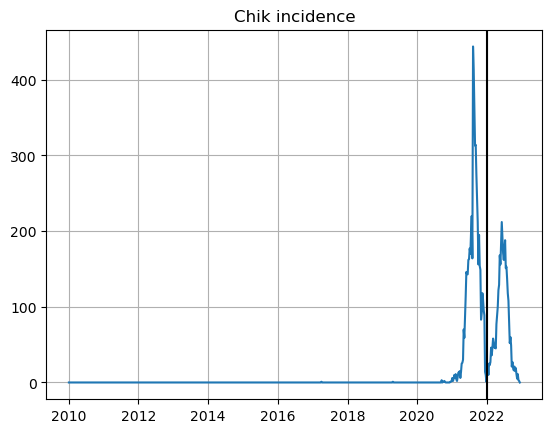

In [4]:
fig,ax = plt.subplots()
ax.plot(df_.casos_2507507)

ax.axvline(pd.to_datetime('2022-01-01'), color = 'black')

ax.grid()

ax.set_title('Chik incidence')

## Neural network model 

Parameters of the models:

In [5]:
END_DATE = '2022-02-06' # assign the last day used to evaluate the dengue model 

PREDICT_N = 4 # number of new days predicted
LOOK_BACK = 4 # number of last days used to make the prediction 
EPOCHS = 400
HIDDEN = 8
FEAT = 104 # number of features

Let's train the model with the loss function == msle 

Compilation Time :  0.0030908584594726562
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 4, 104)]          0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 4, 8)             7232      
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 4, 8)              0         
                                                                 
 lstm_1 (LSTM)               (None, 8)                 544       
                                                                 
 dropout_2 (Dropout)         (None, 8)                 0         
  

2023-03-11 19:29:58.695562: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


397/397 [==============================] - 3s 4ms/step - loss: 0.0050 - accuracy: 0.2720 - mape: 5739780.5000 - mse: 0.0068 - val_loss: 0.0022 - val_accuracy: 0.2676 - val_mape: 1545235.1250 - val_mse: 0.0030
Epoch 2/400
397/397 [==============================] - 1s 3ms/step - loss: 0.0022 - accuracy: 0.2443 - mape: 2015178.1250 - mse: 0.0030 - val_loss: 0.0017 - val_accuracy: 0.2958 - val_mape: 749223.4375 - val_mse: 0.0025
Epoch 3/400
397/397 [==============================] - 1s 3ms/step - loss: 0.0017 - accuracy: 0.2645 - mape: 1988936.7500 - mse: 0.0025 - val_loss: 0.0020 - val_accuracy: 0.2535 - val_mape: 710054.6250 - val_mse: 0.0028
Epoch 4/400
397/397 [==============================] - 1s 3ms/step - loss: 0.0014 - accuracy: 0.2620 - mape: 1698205.5000 - mse: 0.0020 - val_loss: 0.0012 - val_accuracy: 0.3239 - val_mape: 1133733.5000 - val_mse: 0.0016
Epoch 5/400
397/397 [==============================] - 1s 3ms/step - loss: 0.0014 - accuracy: 0.3123 - mape: 1078931.6250 - mse: 0

397/397 [==============================] - 1s 4ms/step - loss: 7.9789e-04 - accuracy: 0.3174 - mape: 573404.7500 - mse: 0.0011 - val_loss: 9.7453e-04 - val_accuracy: 0.2394 - val_mape: 252775.0938 - val_mse: 0.0014
Epoch 38/400
397/397 [==============================] - 1s 4ms/step - loss: 9.0306e-04 - accuracy: 0.2821 - mape: 583812.1250 - mse: 0.0013 - val_loss: 7.4032e-04 - val_accuracy: 0.4085 - val_mape: 934750.9375 - val_mse: 0.0010
Epoch 39/400
397/397 [==============================] - 1s 4ms/step - loss: 9.7285e-04 - accuracy: 0.3451 - mape: 656311.8750 - mse: 0.0014 - val_loss: 7.3509e-04 - val_accuracy: 0.3662 - val_mape: 186573.0156 - val_mse: 0.0010
Epoch 40/400
397/397 [==============================] - 1s 4ms/step - loss: 7.4925e-04 - accuracy: 0.3073 - mape: 435198.0000 - mse: 0.0010 - val_loss: 7.1682e-04 - val_accuracy: 0.2535 - val_mape: 397812.3125 - val_mse: 9.6275e-04
Epoch 41/400
397/397 [==============================] - 1s 4ms/step - loss: 9.0802e-04 - accuracy

Epoch 73/400
397/397 [==============================] - 2s 4ms/step - loss: 7.0708e-04 - accuracy: 0.4332 - mape: 327539.7812 - mse: 9.8602e-04 - val_loss: 0.0011 - val_accuracy: 0.4507 - val_mape: 398751.1250 - val_mse: 0.0015
Epoch 74/400
397/397 [==============================] - 2s 4ms/step - loss: 7.4250e-04 - accuracy: 0.4257 - mape: 163791.9062 - mse: 0.0010 - val_loss: 0.0011 - val_accuracy: 0.4085 - val_mape: 68.7834 - val_mse: 0.0015
Epoch 75/400
397/397 [==============================] - 2s 4ms/step - loss: 7.8470e-04 - accuracy: 0.4307 - mape: 360010.6250 - mse: 0.0011 - val_loss: 8.0934e-04 - val_accuracy: 0.4085 - val_mape: 274373.4688 - val_mse: 0.0011
Epoch 76/400
397/397 [==============================] - 2s 4ms/step - loss: 6.2827e-04 - accuracy: 0.4257 - mape: 185517.1406 - mse: 8.5415e-04 - val_loss: 7.9090e-04 - val_accuracy: 0.4366 - val_mape: 59.2121 - val_mse: 0.0011
Epoch 77/400
397/397 [==============================] - 2s 4ms/step - loss: 6.9469e-04 - accurac

Epoch 109/400
397/397 [==============================] - 2s 4ms/step - loss: 5.6371e-04 - accuracy: 0.4761 - mape: 167733.8906 - mse: 7.7258e-04 - val_loss: 6.2838e-04 - val_accuracy: 0.4789 - val_mape: 56.6835 - val_mse: 8.1428e-04
Epoch 110/400
397/397 [==============================] - 2s 4ms/step - loss: 5.9324e-04 - accuracy: 0.4710 - mape: 218042.2969 - mse: 8.0851e-04 - val_loss: 7.2002e-04 - val_accuracy: 0.4085 - val_mape: 559366.9375 - val_mse: 9.9580e-04
Epoch 111/400
397/397 [==============================] - 2s 4ms/step - loss: 6.1294e-04 - accuracy: 0.4660 - mape: 239923.1250 - mse: 8.3266e-04 - val_loss: 6.7322e-04 - val_accuracy: 0.3944 - val_mape: 47.7063 - val_mse: 9.4367e-04
Epoch 112/400
397/397 [==============================] - 2s 4ms/step - loss: 6.2113e-04 - accuracy: 0.4484 - mape: 193949.3750 - mse: 8.6543e-04 - val_loss: 5.8189e-04 - val_accuracy: 0.3944 - val_mape: 201567.0781 - val_mse: 7.5175e-04
Epoch 113/400
397/397 [==============================] - 2s 

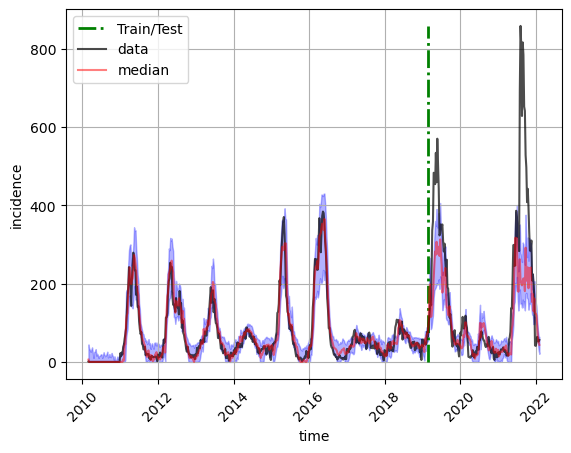

CPU times: user 6min 17s, sys: 21.5 s, total: 6min 38s
Wall time: 5min 49s


In [6]:
%%time

model = build_model(hidden = HIDDEN, features = FEAT, predict_n = PREDICT_N, look_back=LOOK_BACK, batch_size=1, loss = 'msle')

metrics_msle, hist_msle, m_train, m_val = make_pred(model, CITY, doenca = 'dengue', epochs = EPOCHS, end_train_date = None, 
                    ratio= 0.75, end_date = END_DATE,
                     predict_n = PREDICT_N, look_back =  LOOK_BACK, label = 'msle', filename = FILENAME_DATA)

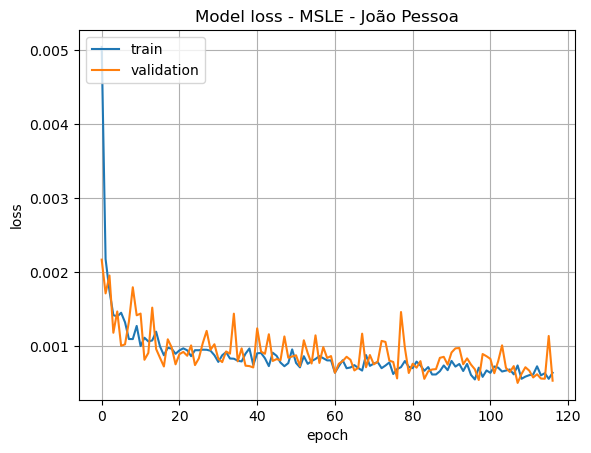

In [7]:
plot_loss(hist_msle, title = 'Model loss - MSLE - João Pessoa')

Now, let's retrain the models with all the data available to apply the transfer learning step later:

Compilation Time :  0.002724885940551758
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 4, 104)]          0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 4, 8)             7232      
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 4, 8)              0         
                                                                 
 lstm_1 (LSTM)               (None, 8)                 544       
                                                                 
 dropout_2 (Dropout)         (None, 8)                 0         
 

529/529 [==============================] - 2s 4ms/step - loss: 0.0017 - accuracy: 0.3422 - mape: 623165.6250 - mse: 0.0030 - val_loss: 0.0021 - val_accuracy: 0.3191 - val_mape: 183174.9375 - val_mse: 0.0043
Epoch 32/400
529/529 [==============================] - 2s 4ms/step - loss: 0.0017 - accuracy: 0.3308 - mape: 639911.0625 - mse: 0.0030 - val_loss: 0.0026 - val_accuracy: 0.4149 - val_mape: 52.7573 - val_mse: 0.0059
Epoch 33/400
529/529 [==============================] - 2s 4ms/step - loss: 0.0015 - accuracy: 0.3535 - mape: 433619.2188 - mse: 0.0025 - val_loss: 0.0028 - val_accuracy: 0.3404 - val_mape: 10880.9883 - val_mse: 0.0069
Epoch 34/400
529/529 [==============================] - 2s 5ms/step - loss: 0.0015 - accuracy: 0.3535 - mape: 456021.1875 - mse: 0.0026 - val_loss: 0.0020 - val_accuracy: 0.3511 - val_mape: 107274.0938 - val_mse: 0.0038
Epoch 35/400
529/529 [==============================] - 2s 4ms/step - loss: 0.0017 - accuracy: 0.3440 - mape: 754067.2500 - mse: 0.0030 - 

529/529 [==============================] - 2s 4ms/step - loss: 0.0011 - accuracy: 0.4216 - mape: 377657.2500 - mse: 0.0019 - val_loss: 0.0016 - val_accuracy: 0.3617 - val_mape: 38811.2461 - val_mse: 0.0033
Epoch 69/400
529/529 [==============================] - 2s 5ms/step - loss: 0.0012 - accuracy: 0.4045 - mape: 355919.3125 - mse: 0.0021 - val_loss: 0.0015 - val_accuracy: 0.4255 - val_mape: 20357.8770 - val_mse: 0.0028
Epoch 70/400
529/529 [==============================] - 2s 5ms/step - loss: 0.0013 - accuracy: 0.4159 - mape: 504441.8750 - mse: 0.0025 - val_loss: 0.0015 - val_accuracy: 0.3404 - val_mape: 274128.6562 - val_mse: 0.0029
Epoch 71/400
529/529 [==============================] - 2s 5ms/step - loss: 0.0013 - accuracy: 0.4253 - mape: 302453.1562 - mse: 0.0022 - val_loss: 0.0019 - val_accuracy: 0.4574 - val_mape: 58.3229 - val_mse: 0.0037
Epoch 72/400
529/529 [==============================] - 2s 5ms/step - loss: 0.0013 - accuracy: 0.4064 - mape: 338246.1250 - mse: 0.0023 - v

529/529 [==============================] - 2s 4ms/step - loss: 9.9679e-04 - accuracy: 0.4480 - mape: 476774.5938 - mse: 0.0016 - val_loss: 0.0017 - val_accuracy: 0.4043 - val_mape: 81627.7422 - val_mse: 0.0031
Epoch 106/400
529/529 [==============================] - 2s 4ms/step - loss: 0.0012 - accuracy: 0.4442 - mape: 224507.7969 - mse: 0.0023 - val_loss: 0.0023 - val_accuracy: 0.3936 - val_mape: 208549.9531 - val_mse: 0.0051
Epoch 107/400
529/529 [==============================] - 2s 4ms/step - loss: 0.0012 - accuracy: 0.4386 - mape: 269821.6250 - mse: 0.0021 - val_loss: 0.0016 - val_accuracy: 0.4574 - val_mape: 52.1104 - val_mse: 0.0037
Epoch 108/400
529/529 [==============================] - 2s 5ms/step - loss: 0.0012 - accuracy: 0.4405 - mape: 320470.8125 - mse: 0.0021 - val_loss: 0.0022 - val_accuracy: 0.4149 - val_mape: 52474.2461 - val_mse: 0.0046
Epoch 109/400
529/529 [==============================] - 2s 4ms/step - loss: 0.0012 - accuracy: 0.4348 - mape: 299693.0938 - mse: 0.

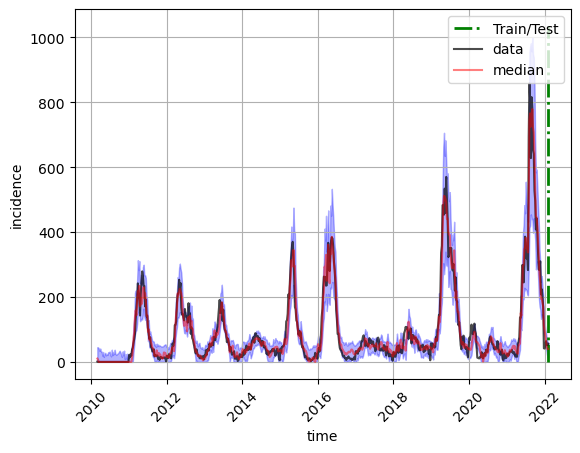

In [8]:
model = build_model(hidden = HIDDEN, features = FEAT, predict_n = PREDICT_N, look_back=LOOK_BACK, batch_size=1, loss = 'msle')

m_msle_all, h_msle_all, m_train_all, m_val_all = make_pred(model, CITY, doenca = 'dengue', epochs = EPOCHS, end_train_date = None, 
                    ratio= 1.0, end_date = END_DATE,
                     predict_n = PREDICT_N, look_back =  LOOK_BACK, label = 'msle_all',  filename = FILENAME_DATA)

PGBM model

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Estimator 0/100, Train metric: 71.0257
Estimator 1/100, Train metric: 64.7025
Estimator 2/100, Train metric: 58.9738
Estimator 3/100, Train metric: 53.7467
Estimator 4/100, Train metric: 48.9793
Estimator 5/100, Train metric: 44.7324
Estimator 6/100, Train metric: 40.8318
Estimator 7/100, Train metric: 37.3075
Estimator 8/100, Train metric: 34.0828
Estimator 9/100, Train metric: 31.2170
Estimator 10/100, Train metric: 28.6080
Estimator 11/100, Train metric: 26.2568
Estimator 12/100, Train metric: 24.0580
Estimator 13/100, Train metric: 22.0931
Estimator 14/100, Train metric: 20.3026
Estimator 15/100, Train metric: 18.6835
Estimator 16/100, Train metric: 17.2032
Estimator 17/100, Train metric: 15.8790
Estimator 18/100, Train metric: 14.6717
Estimator 19/100, Train metric: 13.5794
Estimator 20/100, Train metric: 12.5704
Estimator 21/100, Train metric: 11.6727
Estimator 22/100, Train metric: 10.8570
Estimator 23/100, Train metric: 10.0897
Estimator 24/100, Train metric: 9.3939
Estimator 2

Estimator 10/100, Train metric: 29.8699
Estimator 11/100, Train metric: 27.4821
Estimator 12/100, Train metric: 25.3825
Estimator 13/100, Train metric: 23.4269
Estimator 14/100, Train metric: 21.6353
Estimator 15/100, Train metric: 20.0039
Estimator 16/100, Train metric: 18.5431
Estimator 17/100, Train metric: 17.2198
Estimator 18/100, Train metric: 16.0263
Estimator 19/100, Train metric: 14.9168
Estimator 20/100, Train metric: 13.9316
Estimator 21/100, Train metric: 13.0119
Estimator 22/100, Train metric: 12.1849
Estimator 23/100, Train metric: 11.4313
Estimator 24/100, Train metric: 10.7206
Estimator 25/100, Train metric: 10.1040
Estimator 26/100, Train metric: 9.5449
Estimator 27/100, Train metric: 9.0233
Estimator 28/100, Train metric: 8.5749
Estimator 29/100, Train metric: 8.1350
Estimator 30/100, Train metric: 7.7650
Estimator 31/100, Train metric: 7.3977
Estimator 32/100, Train metric: 7.0731
Estimator 33/100, Train metric: 6.7557
Estimator 34/100, Train metric: 6.5068
Estimator

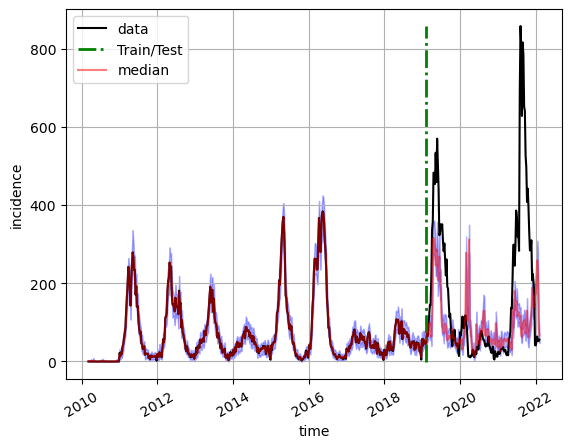

In [9]:

preds, preds25, preds975, X_train, targets = pgbm_pred(CITY, STATE, predict_n = PREDICT_N, look_back = LOOK_BACK,
                                                           doenca = 'dengue', ratio = 0.75, ini_date = None,
                                                           end_date = END_DATE, label = 'train_test',  filename = FILENAME_DATA)

Estimator 0/100, Train metric: 115.9200
Estimator 1/100, Train metric: 105.8397
Estimator 2/100, Train metric: 96.7136
Estimator 3/100, Train metric: 88.4446
Estimator 4/100, Train metric: 80.9230
Estimator 5/100, Train metric: 74.0922
Estimator 6/100, Train metric: 67.9207
Estimator 7/100, Train metric: 62.1358
Estimator 8/100, Train metric: 56.9202
Estimator 9/100, Train metric: 52.2197
Estimator 10/100, Train metric: 47.9877
Estimator 11/100, Train metric: 44.1438
Estimator 12/100, Train metric: 40.6384
Estimator 13/100, Train metric: 37.4743
Estimator 14/100, Train metric: 34.6167
Estimator 15/100, Train metric: 31.9524
Estimator 16/100, Train metric: 29.5428
Estimator 17/100, Train metric: 27.3900
Estimator 18/100, Train metric: 25.4155
Estimator 19/100, Train metric: 23.6151
Estimator 20/100, Train metric: 21.9656
Estimator 21/100, Train metric: 20.4553
Estimator 22/100, Train metric: 19.0813
Estimator 23/100, Train metric: 17.8432
Estimator 24/100, Train metric: 16.7009
Estimato

Estimator 9/100, Train metric: 53.7281
Estimator 10/100, Train metric: 49.5637
Estimator 11/100, Train metric: 45.8475
Estimator 12/100, Train metric: 42.4085
Estimator 13/100, Train metric: 39.2117
Estimator 14/100, Train metric: 36.2991
Estimator 15/100, Train metric: 33.7635
Estimator 16/100, Train metric: 31.3692
Estimator 17/100, Train metric: 29.1868
Estimator 18/100, Train metric: 27.2091
Estimator 19/100, Train metric: 25.4176
Estimator 20/100, Train metric: 23.8097
Estimator 21/100, Train metric: 22.3841
Estimator 22/100, Train metric: 20.9987
Estimator 23/100, Train metric: 19.7690
Estimator 24/100, Train metric: 18.6832
Estimator 25/100, Train metric: 17.6213
Estimator 26/100, Train metric: 16.6623
Estimator 27/100, Train metric: 15.8055
Estimator 28/100, Train metric: 15.0454
Estimator 29/100, Train metric: 14.3317
Estimator 30/100, Train metric: 13.6931
Estimator 31/100, Train metric: 13.0500
Estimator 32/100, Train metric: 12.4828
Estimator 33/100, Train metric: 11.9820
E

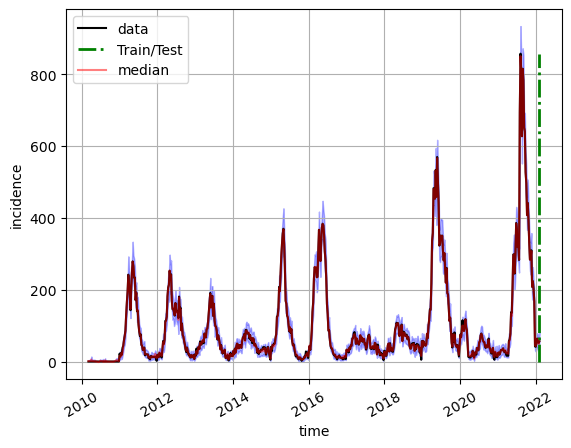

In [10]:
preds, preds25, preds975, X_train, targets = pgbm_pred(CITY, STATE, PREDICT_N, LOOK_BACK, doenca = 'dengue', ini_date = None, end_train_date = END_DATE, end_date = END_DATE,  filename = FILENAME_DATA)
   